In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
transactions     = pd.read_csv("../sales_train_v2.csv")
items            = pd.read_csv("../items.csv")
item_categories  = pd.read_csv("../item_categories.csv")
shops            = pd.read_csv("../shops.csv")
test             = pd.read_csv("../test.csv")

In [6]:
print("train:", transactions.shape, transactions.columns)
print("test:", test.shape, test.columns)
print("shop:", shops.shape, shops.columns)
print("items:", items.shape, items.columns)
print("categories:", item_categories.shape, item_categories.columns)

train: (2935849, 6) Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
test: (214200, 3) Index(['ID', 'shop_id', 'item_id'], dtype='object')
shop: (60, 2) Index(['shop_name', 'shop_id'], dtype='object')
items: (22170, 3) Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
categories: (84, 2) Index(['item_category_name', 'item_category_id'], dtype='object')


In [7]:
train

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [36]:
transactions["date_format"] = pd.to_datetime(transactions.date, format = "%d.%m.%Y")

In [37]:
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_format
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15


In [115]:
transactions[transactions.item_cnt_day > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_format
2909818,28.10.2015,33,12,11373,0.908714,2169.0,2015-10-28


In [92]:
test.tail(5)

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [49]:
print("All the date blocks in the train:\n", transactions.date_block_num.unique())


All the date blocks in the train:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


Facts:
- There are 60 shops, 22170 items and 84 categorites
- There are 34 date blocks(34 months) in the train, we will predict the sale in 35th date(November) block for each shop_id, item_id pair in the test.
- It seems that the total row number in the test is regularized, the way this doc was constructed can be further exploited

In [34]:
shop_in_test = test.shop_id.unique()
shop_in_train = transactions.shop_id.unique()
shop_not_used = []
for shop in shop_in_train:
    if shop not in shop_in_test:
        shop_not_used.append(shop)
shop_not_used.sort()
print("Those shops don't appear in test but appear in the train:\n", shop_not_used)

Those shops don't appear in test but appear in the train:
 [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]


In [52]:
test.groupby(test.shop_id).count().head()

,ID,item_id
shop_id,,
2,5100,5100
3,5100,5100
4,5100,5100
5,5100,5100
6,5100,5100


In [98]:
print(test.shop_id.unique())
print("total numbre of the shops in the test:", test.shop_id.nunique())

[ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53 52
 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]
total numbre of the shops in the test: 42


- 42*5100 = 214200, this is how the test doc was constructed
- It should be aweared that there are 22170 items in total, but only 5100 are requested to be predicted.

In [76]:
transactions_drop_shops = transactions[transactions["shop_id"] == 0 | 1 | 8| 9| 11| 13| 17| 20| 23| 27| 29| 30| 32| 33| 40| 43| 51| 54]
temp = transactions.drop(transactions_drop_shops.index)
temp

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_format
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15
5,10.01.2013,0,25,2564,349.00,1.0,2013-01-10
6,02.01.2013,0,25,2565,549.00,1.0,2013-01-02
7,04.01.2013,0,25,2572,239.00,1.0,2013-01-04
8,11.01.2013,0,25,2572,299.00,1.0,2013-01-11
9,03.01.2013,0,25,2573,299.00,3.0,2013-01-03


In [85]:
a = temp.groupby(temp.date_block_num).item_id.unique()
cross = []
for i in range(30000):
    for j in range(34):
        if i not in a[j]:
            break
        elif j == 33:
            cross.append(i)

5100 not equal to items appear in the shops we are to predicted in the train doc, so how those 5100 items are selected remain to be a mistery.

In [88]:
len(cross)

523

# EDA

## Sum of count per month 

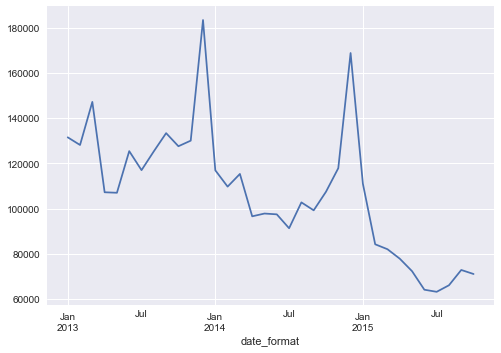

In [89]:
plt.style.use("seaborn")
transactions.copy().set_index("date_format").item_cnt_day.resample("M").sum().plot()

(24, 35)

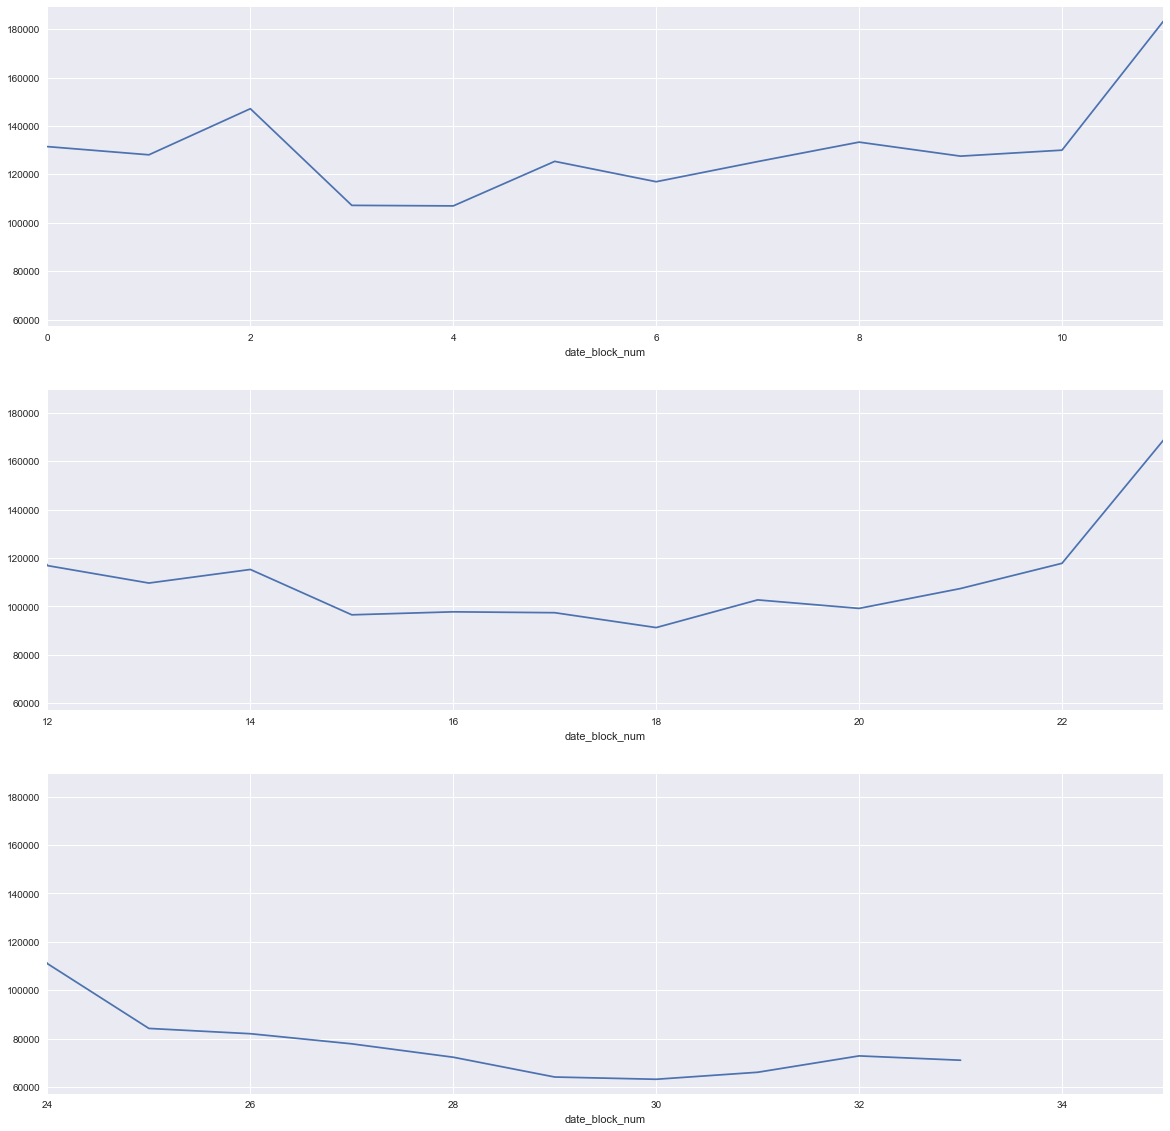

In [120]:
# general situation for every year
plt.figure(figsize=(20,20))
plt.subplot(311)
transactions.groupby(transactions.date_block_num).item_cnt_day.sum().plot()
plt.xlim(0, 11)
plt.xlabel
plt.subplot(312)
transactions.groupby(transactions.date_block_num).item_cnt_day.sum().plot()
plt.xlim(12, 23)
plt.subplot(313)
transactions.groupby(transactions.date_block_num).item_cnt_day.sum().plot()
plt.xlim(24, 35)

There do exist some obvious patterns iterms of one year
- December and January hopefully will get more sales 
- The sales in the whole summer are low
- It seems that the whole line is dropping down(maybe due to the macro economy)
I also did some investigation about the economy of Russia:<p>
| Year | GDP |<p>
| 2013 | 2.231 |<p>
| 2014 | 2.064 |<p>
| 2015 | 1.366 |



## Some thoughs and conclusions
- Add bealoon features for those months which possess significantly high sales
- Lags are quite important for this problem, especially 12-month lags, 24-month lags, 1-month lags
- Season should be taken into consideration, the sale in the whole summer is low(虽然我们预测的是11月,但是给有些规律是每个月销量预测中普适的,这些我们需要从其他的月份中取寻找归纳; 有的是月份所特有的,比如夏季是淡季这样的规律,我们需要打上标签,把这样的因素从普适规律中剔除掉, 给1月,12月打上标签也是同理)